# Model Testing

### The steps in this notebook are extremely time consuming.

### For the purpose of not having these experiments running afect my work in the main notebook I separated them for paralel running

In [26]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

#imports to help me plot my venn diagrams
import matplotlib_venn as venn2
from matplotlib_venn import venn2
from pylab import rcParams

# import the util.py file where I define my functions
from utils import *

# sklearn
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix,precision_recall_fscore_support
from sklearn.utils.multiclass import unique_labels
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score, recall_score

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold, learning_curve

from sklearn import ensemble
from sklearn import model_selection

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

import xgboost as xgb
import lightgbm as lgb

import skopt
from skopt import BayesSearchCV
class BayesSearchCV(BayesSearchCV):
    def _run_search(self, x): raise BaseException('Use newer skopt')

# magic word for producing visualizations in notebook
%matplotlib inline

import time
from timeit import default_timer as timer

In [2]:
mailout_train = pd.read_csv(r"C:\Users\sousa\Desktop\github\Arvato\data\mailout_train.csv")
mailout_test = pd.read_csv(r"C:\Users\sousa\Desktop\github\Arvato\data\mailout_test.csv")
dias_xls = pd.read_excel(r"C:\Users\sousa\Desktop\github\Arvato\data\DIAS Attributes - Values 2017.xlsx", header = 1)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
#getting the target
target = mailout_train['RESPONSE']
mailout_train = mailout_train.drop(['RESPONSE'], axis=1)

In [4]:
#running all the cleaning and feature transformation functions
#fixing the mixed type columns
mailout_train = special_feature_handler(mailout_train)
mailout_test = special_feature_handler(mailout_test)

#dealing with missing and unknowns
unknowns_to_NANs(mailout_train, dias_xls)
unknowns_to_NANs(mailout_test, dias_xls)

#getting percentages of missing
percent_missing_train = percentage_of_missing(mailout_train)
percent_missing_test = percentage_of_missing(mailout_test)

#getting missing over 30%
train_missing_over_30 = split_on_percentage(percent_missing_train, 30, '>')
test_missing_over_30 = split_on_percentage(percent_missing_test, 30, '>')

#getting columns to delete
train_col_delete = columns_to_delete(train_missing_over_30)
test_col_delete = columns_to_delete(test_missing_over_30)

#dropping cols
mailout_train = mailout_train.drop(train_col_delete, axis = 1)
mailout_test = mailout_test.drop(test_col_delete, axis = 1)

#feature engineering
mailout_train = feat_eng(mailout_train)
mailout_test = feat_eng(mailout_test)

Creating PRAEGENDE_JUGENDJAHRE_DECADE feature
Creating PRAEGENDE_JUGENDJAHRE_MOVEMENT feature
Creating WOHNLAGE_QUALITY feature
Creating WOHNLAGE_AREA feature
Creating Wealth and Family feature
Creating LP_LEBENSPHASE_FEIN_life_stage and LP_LEBENSPHASE_FEIN_fine_scale feature
Creating PRAEGENDE_JUGENDJAHRE_DECADE feature
Creating PRAEGENDE_JUGENDJAHRE_MOVEMENT feature
Creating WOHNLAGE_QUALITY feature
Creating WOHNLAGE_AREA feature
Creating Wealth and Family feature
Creating LP_LEBENSPHASE_FEIN_life_stage and LP_LEBENSPHASE_FEIN_fine_scale feature


In [5]:
#dropping LNR
mailout_train.drop(['LNR'], axis = 1, inplace = True)
mailout_test.drop(['LNR'], axis = 1, inplace = True)

In [7]:
balance_checker(mailout_train, mailout_test)

Feature balance between dfs?:  True


In [8]:
SEED = 28

In [9]:
# 5 stratified folds
skf = StratifiedKFold(n_splits=5, random_state=SEED, shuffle=True)
skf.get_n_splits(mailout_train, target)

5

LR: 0.665969 (0.010033)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


roc auc train score = 0.81
roc auc validation score = 0.67



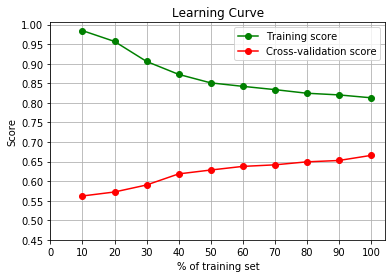

RF: 0.635064 (0.022029)
roc auc train score = 0.98
roc auc validation score = 0.63



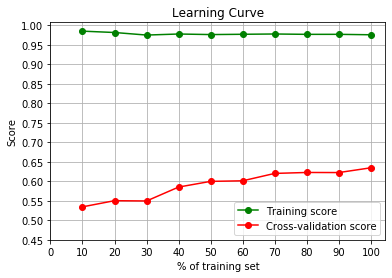

XGB: 0.760671 (0.013216)
roc auc train score = 0.89
roc auc validation score = 0.76



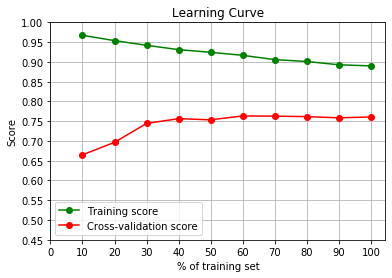

LGBM: 0.711664 (0.012695)
roc auc train score = 0.99
roc auc validation score = 0.71



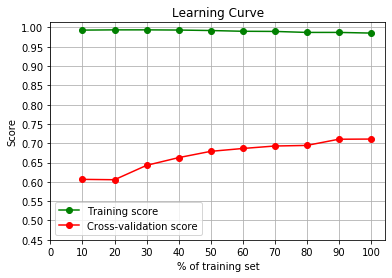

GB: 0.757078 (0.005977)
roc auc train score = 0.91
roc auc validation score = 0.76



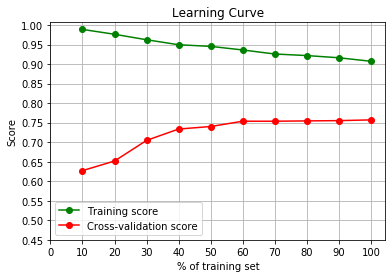

MLP: 0.602555 (0.066299)
roc auc train score = 0.69
roc auc validation score = 0.6



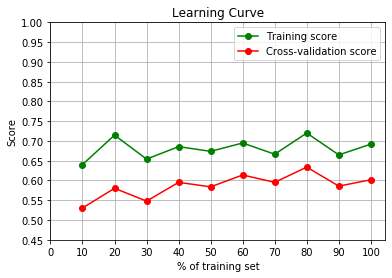

Wall time: 1h 55min 28s


,Model,Score
0,LR,0.6660
1,RF,0.6351
2,XGB,0.7607
3,LGBM,0.7117
4,GB,0.7571
5,MLP,0.6026


In [14]:
%%time
#unscaled 
models = create_base_models()
names, results = evaluate(mailout_train, target, models, curve=True)
baseline_score = create_score_df(names, results)
baseline_score

In [15]:
%%time
# standard scaler
models = get_scaled_preprocess('standard')
names, results = evaluate(mailout_train, target, models)
standard_scaler_score = create_score_df(names, results)

df_score = pd.concat([baseline_score, standard_scaler_score], axis=1)
df_score

standardLR: 0.661333 (0.008479)
standardRF: 0.637601 (0.022527)
standardXGB: 0.760671 (0.013216)
standardLGBM: 0.719065 (0.012509)
standardGB: 0.757103 (0.005993)
standardMLP: 0.591484 (0.016738)
Wall time: 16min 43s


,Model,Score,Model,Score
0,LR,0.6660,standardLR,0.6613
1,RF,0.6351,standardRF,0.6376
2,XGB,0.7607,standardXGB,0.7607
3,LGBM,0.7117,standardLGBM,0.7191
4,GB,0.7571,standardGB,0.7571
5,MLP,0.6026,standardMLP,0.5915


In [16]:
%%time
# minmax scaler
models = get_scaled_preprocess('minmax')
names, results = evaluate(mailout_train, target, models)
minmax_scaler_score = create_score_df(names, results)

df_score = pd.concat([df_score, minmax_scaler_score], axis=1)
df_score

minmaxLR: 0.674468 (0.010468)
minmaxRF: 0.635189 (0.022054)
minmaxXGB: 0.760671 (0.013216)
minmaxLGBM: 0.711664 (0.012695)
minmaxGB: 0.757075 (0.005976)
minmaxMLP: 0.591423 (0.022363)
Wall time: 19min 11s


,Model,Score,Model,Score,Model,Score
0,LR,0.6660,standardLR,0.6613,minmaxLR,0.6745
1,RF,0.6351,standardRF,0.6376,minmaxRF,0.6352
2,XGB,0.7607,standardXGB,0.7607,minmaxXGB,0.7607
3,LGBM,0.7117,standardLGBM,0.7191,minmaxLGBM,0.7117
4,GB,0.7571,standardGB,0.7571,minmaxGB,0.7571
5,MLP,0.6026,standardMLP,0.5915,minmaxMLP,0.5914


#Since both standard scaler and min max scaler perform equally well I will stick with minmaxscaler

### Setting up different scaling strategies

#### Min Max Scaler

In [17]:
scaler = MinMaxScaler()
scaler.fit(mailout_train.astype('float'))

mailout_train_scaled = scaler.transform(mailout_train)
mailout_test_scaled = scaler.transform(mailout_test)

# map back to dfs
mailout_train_scaled = pd.DataFrame(data=mailout_train_scaled, columns=mailout_train.columns)
mailout_test_scaled = pd.DataFrame(data=mailout_test_scaled, columns=mailout_test.columns)

#### Standard Scaler

In [ ]:
scaler = StandardScaler()
scaler.fit(mailout_train.astype('float'))

mailout_train_scaled = scaler.transform(mailout_train)
mailout_test_scaled = scaler.transform(mailout_test)

# map back to dfs
mailout_train_scaled = pd.DataFrame(data=mailout_train_scaled, columns=mailout_train.columns)
mailout_test_scaled = pd.DataFrame(data=mailout_test_scaled, columns=mailout_test.columns)

### Hyperparameter tunning lgbm

In [18]:
ITERATIONS = 500
bayes_cv_tuner_lgbm = BayesSearchCV(
    estimator = lgb.LGBMClassifier(
        application='binary',
        metric='auc',
        n_jobs=-1,
        verbose=0
    ),
    search_spaces = {
        'learning_rate': (0.01, 0.5, 'uniform'),
        'num_leaves': (2, 225),      
        'max_depth': (2, 10),
        'colsample_bytree':(0.5, 1.0, 'uniform'),
        "min_data_in_leaf":(20, 100),
        'min_child_samples': (0, 50),
        'max_bin': (100, 1000),
        'reg_lambda': (1e-9, 1.0, 'log-uniform'),
        'reg_alpha': (1e-9, 1.0, 'log-uniform'),
        'scale_pos_weight': (1,90, 'uniform'),
        'n_estimators': (20, 400),
},    
    scoring = 'roc_auc',
    cv = StratifiedKFold(
        n_splits=5,
        shuffle=True,
        random_state=SEED
    ),
    n_jobs = -1,
    n_iter = ITERATIONS,   
    verbose = 0,
    refit = True,
    random_state = SEED
)

def status_print(optim_result):
    """Status callback durring bayesian hyperparameter search"""
    
    # Get all the models tested so far in DataFrame format
    all_models = pd.DataFrame(bayes_cv_tuner_lgbm.cv_results_)    
    
    # Get current parameters and the best parameters    
    best_params = pd.Series(bayes_cv_tuner_lgbm.best_params_)
    print('Model #{}\nBest ROC-AUC: {}\nBest params: {}\n'.format(
        len(all_models),
        np.round(bayes_cv_tuner_lgbm.best_score_, 4),
        bayes_cv_tuner_lgbm.best_params_
    ))
    
    # Save all model results
    clf_name = bayes_cv_tuner_lgbm.estimator.__class__.__name__
    all_models.to_csv(clf_name+"_cv_results.csv")

In [19]:
%%time
result_lgbm = bayes_cv_tuner_lgbm.fit(mailout_train_scaled, target, callback=status_print)

Model #1
Best ROC-AUC: 0.6133
Best params: {'colsample_bytree': 0.6423458841498082, 'learning_rate': 0.22971060454557746, 'max_bin': 463, 'max_depth': 5, 'min_child_samples': 29, 'min_data_in_leaf': 61, 'n_estimators': 50, 'num_leaves': 91, 'reg_alpha': 4.388532829429149e-09, 'reg_lambda': 0.0003562600996233536, 'scale_pos_weight': 61.32434088946515}

Model #2
Best ROC-AUC: 0.6133
Best params: {'colsample_bytree': 0.6423458841498082, 'learning_rate': 0.22971060454557746, 'max_bin': 463, 'max_depth': 5, 'min_child_samples': 29, 'min_data_in_leaf': 61, 'n_estimators': 50, 'num_leaves': 91, 'reg_alpha': 4.388532829429149e-09, 'reg_lambda': 0.0003562600996233536, 'scale_pos_weight': 61.32434088946515}

Model #3
Best ROC-AUC: 0.6133
Best params: {'colsample_bytree': 0.6423458841498082, 'learning_rate': 0.22971060454557746, 'max_bin': 463, 'max_depth': 5, 'min_child_samples': 29, 'min_data_in_leaf': 61, 'n_estimators': 50, 'num_leaves': 91, 'reg_alpha': 4.388532829429149e-09, 'reg_lambda': 0

Model #25
Best ROC-AUC: 0.7658
Best params: {'colsample_bytree': 0.690494353091413, 'learning_rate': 0.03606938695061905, 'max_bin': 214, 'max_depth': 2, 'min_child_samples': 0, 'min_data_in_leaf': 47, 'n_estimators': 20, 'num_leaves': 225, 'reg_alpha': 1.5141281044471475e-07, 'reg_lambda': 9.340826062867575e-06, 'scale_pos_weight': 78.72674659642794}

Model #26
Best ROC-AUC: 0.7658
Best params: {'colsample_bytree': 0.690494353091413, 'learning_rate': 0.03606938695061905, 'max_bin': 214, 'max_depth': 2, 'min_child_samples': 0, 'min_data_in_leaf': 47, 'n_estimators': 20, 'num_leaves': 225, 'reg_alpha': 1.5141281044471475e-07, 'reg_lambda': 9.340826062867575e-06, 'scale_pos_weight': 78.72674659642794}

Model #27
Best ROC-AUC: 0.7658
Best params: {'colsample_bytree': 0.690494353091413, 'learning_rate': 0.03606938695061905, 'max_bin': 214, 'max_depth': 2, 'min_child_samples': 0, 'min_data_in_leaf': 47, 'n_estimators': 20, 'num_leaves': 225, 'reg_alpha': 1.5141281044471475e-07, 'reg_lambda'

Model #52
Best ROC-AUC: 0.768
Best params: {'colsample_bytree': 0.7485044583944194, 'learning_rate': 0.11625634987398117, 'max_bin': 142, 'max_depth': 2, 'min_child_samples': 9, 'min_data_in_leaf': 47, 'n_estimators': 20, 'num_leaves': 51, 'reg_alpha': 1.2340896261301402e-09, 'reg_lambda': 1.0, 'scale_pos_weight': 74.40362465094736}

Model #53
Best ROC-AUC: 0.768
Best params: {'colsample_bytree': 0.7485044583944194, 'learning_rate': 0.11625634987398117, 'max_bin': 142, 'max_depth': 2, 'min_child_samples': 9, 'min_data_in_leaf': 47, 'n_estimators': 20, 'num_leaves': 51, 'reg_alpha': 1.2340896261301402e-09, 'reg_lambda': 1.0, 'scale_pos_weight': 74.40362465094736}

Model #54
Best ROC-AUC: 0.768
Best params: {'colsample_bytree': 0.7485044583944194, 'learning_rate': 0.11625634987398117, 'max_bin': 142, 'max_depth': 2, 'min_child_samples': 9, 'min_data_in_leaf': 47, 'n_estimators': 20, 'num_leaves': 51, 'reg_alpha': 1.2340896261301402e-09, 'reg_lambda': 1.0, 'scale_pos_weight': 74.403624650

Model #77
Best ROC-AUC: 0.7685
Best params: {'colsample_bytree': 0.6807009842471385, 'learning_rate': 0.11043881399456439, 'max_bin': 100, 'max_depth': 2, 'min_child_samples': 0, 'min_data_in_leaf': 71, 'n_estimators': 20, 'num_leaves': 225, 'reg_alpha': 4.860282165243681e-09, 'reg_lambda': 2.4632049435891286e-06, 'scale_pos_weight': 39.349137693119665}

Model #78
Best ROC-AUC: 0.7685
Best params: {'colsample_bytree': 0.6807009842471385, 'learning_rate': 0.11043881399456439, 'max_bin': 100, 'max_depth': 2, 'min_child_samples': 0, 'min_data_in_leaf': 71, 'n_estimators': 20, 'num_leaves': 225, 'reg_alpha': 4.860282165243681e-09, 'reg_lambda': 2.4632049435891286e-06, 'scale_pos_weight': 39.349137693119665}

Model #79
Best ROC-AUC: 0.7685
Best params: {'colsample_bytree': 0.6807009842471385, 'learning_rate': 0.11043881399456439, 'max_bin': 100, 'max_depth': 2, 'min_child_samples': 0, 'min_data_in_leaf': 71, 'n_estimators': 20, 'num_leaves': 225, 'reg_alpha': 4.860282165243681e-09, 'reg_lam

Model #100
Best ROC-AUC: 0.7685
Best params: {'colsample_bytree': 0.6807009842471385, 'learning_rate': 0.11043881399456439, 'max_bin': 100, 'max_depth': 2, 'min_child_samples': 0, 'min_data_in_leaf': 71, 'n_estimators': 20, 'num_leaves': 225, 'reg_alpha': 4.860282165243681e-09, 'reg_lambda': 2.4632049435891286e-06, 'scale_pos_weight': 39.349137693119665}

Model #101
Best ROC-AUC: 0.7685
Best params: {'colsample_bytree': 0.6807009842471385, 'learning_rate': 0.11043881399456439, 'max_bin': 100, 'max_depth': 2, 'min_child_samples': 0, 'min_data_in_leaf': 71, 'n_estimators': 20, 'num_leaves': 225, 'reg_alpha': 4.860282165243681e-09, 'reg_lambda': 2.4632049435891286e-06, 'scale_pos_weight': 39.349137693119665}

Model #102
Best ROC-AUC: 0.7685
Best params: {'colsample_bytree': 0.6807009842471385, 'learning_rate': 0.11043881399456439, 'max_bin': 100, 'max_depth': 2, 'min_child_samples': 0, 'min_data_in_leaf': 71, 'n_estimators': 20, 'num_leaves': 225, 'reg_alpha': 4.860282165243681e-09, 'reg_

Model #125
Best ROC-AUC: 0.7716
Best params: {'colsample_bytree': 0.8862033454195868, 'learning_rate': 0.0971042500981901, 'max_bin': 191, 'max_depth': 2, 'min_child_samples': 42, 'min_data_in_leaf': 64, 'n_estimators': 20, 'num_leaves': 153, 'reg_alpha': 1.0, 'reg_lambda': 1e-09, 'scale_pos_weight': 61.658110057944185}

Model #126
Best ROC-AUC: 0.7716
Best params: {'colsample_bytree': 0.8862033454195868, 'learning_rate': 0.0971042500981901, 'max_bin': 191, 'max_depth': 2, 'min_child_samples': 42, 'min_data_in_leaf': 64, 'n_estimators': 20, 'num_leaves': 153, 'reg_alpha': 1.0, 'reg_lambda': 1e-09, 'scale_pos_weight': 61.658110057944185}

Model #127
Best ROC-AUC: 0.7716
Best params: {'colsample_bytree': 0.8862033454195868, 'learning_rate': 0.0971042500981901, 'max_bin': 191, 'max_depth': 2, 'min_child_samples': 42, 'min_data_in_leaf': 64, 'n_estimators': 20, 'num_leaves': 153, 'reg_alpha': 1.0, 'reg_lambda': 1e-09, 'scale_pos_weight': 61.658110057944185}

Model #128
Best ROC-AUC: 0.7716

Model #151
Best ROC-AUC: 0.7716
Best params: {'colsample_bytree': 0.8862033454195868, 'learning_rate': 0.0971042500981901, 'max_bin': 191, 'max_depth': 2, 'min_child_samples': 42, 'min_data_in_leaf': 64, 'n_estimators': 20, 'num_leaves': 153, 'reg_alpha': 1.0, 'reg_lambda': 1e-09, 'scale_pos_weight': 61.658110057944185}

Model #152
Best ROC-AUC: 0.7716
Best params: {'colsample_bytree': 0.8862033454195868, 'learning_rate': 0.0971042500981901, 'max_bin': 191, 'max_depth': 2, 'min_child_samples': 42, 'min_data_in_leaf': 64, 'n_estimators': 20, 'num_leaves': 153, 'reg_alpha': 1.0, 'reg_lambda': 1e-09, 'scale_pos_weight': 61.658110057944185}

Model #153
Best ROC-AUC: 0.7716
Best params: {'colsample_bytree': 0.8862033454195868, 'learning_rate': 0.0971042500981901, 'max_bin': 191, 'max_depth': 2, 'min_child_samples': 42, 'min_data_in_leaf': 64, 'n_estimators': 20, 'num_leaves': 153, 'reg_alpha': 1.0, 'reg_lambda': 1e-09, 'scale_pos_weight': 61.658110057944185}

Model #154
Best ROC-AUC: 0.7716

Model #178
Best ROC-AUC: 0.7723
Best params: {'colsample_bytree': 0.8299339799855288, 'learning_rate': 0.08505024841378699, 'max_bin': 100, 'max_depth': 2, 'min_child_samples': 0, 'min_data_in_leaf': 97, 'n_estimators': 20, 'num_leaves': 134, 'reg_alpha': 1e-09, 'reg_lambda': 1e-09, 'scale_pos_weight': 90.0}

Model #179
Best ROC-AUC: 0.7723
Best params: {'colsample_bytree': 0.8299339799855288, 'learning_rate': 0.08505024841378699, 'max_bin': 100, 'max_depth': 2, 'min_child_samples': 0, 'min_data_in_leaf': 97, 'n_estimators': 20, 'num_leaves': 134, 'reg_alpha': 1e-09, 'reg_lambda': 1e-09, 'scale_pos_weight': 90.0}

Model #180
Best ROC-AUC: 0.7723
Best params: {'colsample_bytree': 0.8299339799855288, 'learning_rate': 0.08505024841378699, 'max_bin': 100, 'max_depth': 2, 'min_child_samples': 0, 'min_data_in_leaf': 97, 'n_estimators': 20, 'num_leaves': 134, 'reg_alpha': 1e-09, 'reg_lambda': 1e-09, 'scale_pos_weight': 90.0}

Model #181
Best ROC-AUC: 0.7723
Best params: {'colsample_bytree': 0

Model #205
Best ROC-AUC: 0.7723
Best params: {'colsample_bytree': 0.8299339799855288, 'learning_rate': 0.08505024841378699, 'max_bin': 100, 'max_depth': 2, 'min_child_samples': 0, 'min_data_in_leaf': 97, 'n_estimators': 20, 'num_leaves': 134, 'reg_alpha': 1e-09, 'reg_lambda': 1e-09, 'scale_pos_weight': 90.0}

Model #206
Best ROC-AUC: 0.7723
Best params: {'colsample_bytree': 0.8299339799855288, 'learning_rate': 0.08505024841378699, 'max_bin': 100, 'max_depth': 2, 'min_child_samples': 0, 'min_data_in_leaf': 97, 'n_estimators': 20, 'num_leaves': 134, 'reg_alpha': 1e-09, 'reg_lambda': 1e-09, 'scale_pos_weight': 90.0}

Model #207
Best ROC-AUC: 0.7723
Best params: {'colsample_bytree': 0.8299339799855288, 'learning_rate': 0.08505024841378699, 'max_bin': 100, 'max_depth': 2, 'min_child_samples': 0, 'min_data_in_leaf': 97, 'n_estimators': 20, 'num_leaves': 134, 'reg_alpha': 1e-09, 'reg_lambda': 1e-09, 'scale_pos_weight': 90.0}

Model #208
Best ROC-AUC: 0.7723
Best params: {'colsample_bytree': 0

Model #232
Best ROC-AUC: 0.7723
Best params: {'colsample_bytree': 0.8299339799855288, 'learning_rate': 0.08505024841378699, 'max_bin': 100, 'max_depth': 2, 'min_child_samples': 0, 'min_data_in_leaf': 97, 'n_estimators': 20, 'num_leaves': 134, 'reg_alpha': 1e-09, 'reg_lambda': 1e-09, 'scale_pos_weight': 90.0}

Model #233
Best ROC-AUC: 0.7723
Best params: {'colsample_bytree': 0.8299339799855288, 'learning_rate': 0.08505024841378699, 'max_bin': 100, 'max_depth': 2, 'min_child_samples': 0, 'min_data_in_leaf': 97, 'n_estimators': 20, 'num_leaves': 134, 'reg_alpha': 1e-09, 'reg_lambda': 1e-09, 'scale_pos_weight': 90.0}

Model #234
Best ROC-AUC: 0.7723
Best params: {'colsample_bytree': 0.8299339799855288, 'learning_rate': 0.08505024841378699, 'max_bin': 100, 'max_depth': 2, 'min_child_samples': 0, 'min_data_in_leaf': 97, 'n_estimators': 20, 'num_leaves': 134, 'reg_alpha': 1e-09, 'reg_lambda': 1e-09, 'scale_pos_weight': 90.0}

Model #235
Best ROC-AUC: 0.774
Best params: {'colsample_bytree': 1.

Model #260
Best ROC-AUC: 0.774
Best params: {'colsample_bytree': 1.0, 'learning_rate': 0.0882410095694084, 'max_bin': 826, 'max_depth': 2, 'min_child_samples': 0, 'min_data_in_leaf': 32, 'n_estimators': 20, 'num_leaves': 94, 'reg_alpha': 1.0, 'reg_lambda': 1e-09, 'scale_pos_weight': 90.0}

Model #261
Best ROC-AUC: 0.774
Best params: {'colsample_bytree': 1.0, 'learning_rate': 0.0882410095694084, 'max_bin': 826, 'max_depth': 2, 'min_child_samples': 0, 'min_data_in_leaf': 32, 'n_estimators': 20, 'num_leaves': 94, 'reg_alpha': 1.0, 'reg_lambda': 1e-09, 'scale_pos_weight': 90.0}

Model #262
Best ROC-AUC: 0.774
Best params: {'colsample_bytree': 1.0, 'learning_rate': 0.0882410095694084, 'max_bin': 826, 'max_depth': 2, 'min_child_samples': 0, 'min_data_in_leaf': 32, 'n_estimators': 20, 'num_leaves': 94, 'reg_alpha': 1.0, 'reg_lambda': 1e-09, 'scale_pos_weight': 90.0}

Model #263
Best ROC-AUC: 0.774
Best params: {'colsample_bytree': 1.0, 'learning_rate': 0.0882410095694084, 'max_bin': 826, 'max

Model #289
Best ROC-AUC: 0.774
Best params: {'colsample_bytree': 1.0, 'learning_rate': 0.0882410095694084, 'max_bin': 826, 'max_depth': 2, 'min_child_samples': 0, 'min_data_in_leaf': 32, 'n_estimators': 20, 'num_leaves': 94, 'reg_alpha': 1.0, 'reg_lambda': 1e-09, 'scale_pos_weight': 90.0}

Model #290
Best ROC-AUC: 0.774
Best params: {'colsample_bytree': 1.0, 'learning_rate': 0.0882410095694084, 'max_bin': 826, 'max_depth': 2, 'min_child_samples': 0, 'min_data_in_leaf': 32, 'n_estimators': 20, 'num_leaves': 94, 'reg_alpha': 1.0, 'reg_lambda': 1e-09, 'scale_pos_weight': 90.0}

Model #291
Best ROC-AUC: 0.774
Best params: {'colsample_bytree': 1.0, 'learning_rate': 0.0882410095694084, 'max_bin': 826, 'max_depth': 2, 'min_child_samples': 0, 'min_data_in_leaf': 32, 'n_estimators': 20, 'num_leaves': 94, 'reg_alpha': 1.0, 'reg_lambda': 1e-09, 'scale_pos_weight': 90.0}

Model #292
Best ROC-AUC: 0.774
Best params: {'colsample_bytree': 1.0, 'learning_rate': 0.0882410095694084, 'max_bin': 826, 'max

Model #318
Best ROC-AUC: 0.774
Best params: {'colsample_bytree': 1.0, 'learning_rate': 0.0882410095694084, 'max_bin': 826, 'max_depth': 2, 'min_child_samples': 0, 'min_data_in_leaf': 32, 'n_estimators': 20, 'num_leaves': 94, 'reg_alpha': 1.0, 'reg_lambda': 1e-09, 'scale_pos_weight': 90.0}

Model #319
Best ROC-AUC: 0.774
Best params: {'colsample_bytree': 1.0, 'learning_rate': 0.0882410095694084, 'max_bin': 826, 'max_depth': 2, 'min_child_samples': 0, 'min_data_in_leaf': 32, 'n_estimators': 20, 'num_leaves': 94, 'reg_alpha': 1.0, 'reg_lambda': 1e-09, 'scale_pos_weight': 90.0}

Model #320
Best ROC-AUC: 0.774
Best params: {'colsample_bytree': 1.0, 'learning_rate': 0.0882410095694084, 'max_bin': 826, 'max_depth': 2, 'min_child_samples': 0, 'min_data_in_leaf': 32, 'n_estimators': 20, 'num_leaves': 94, 'reg_alpha': 1.0, 'reg_lambda': 1e-09, 'scale_pos_weight': 90.0}

Model #321
Best ROC-AUC: 0.774
Best params: {'colsample_bytree': 1.0, 'learning_rate': 0.0882410095694084, 'max_bin': 826, 'max

Model #347
Best ROC-AUC: 0.774
Best params: {'colsample_bytree': 1.0, 'learning_rate': 0.0882410095694084, 'max_bin': 826, 'max_depth': 2, 'min_child_samples': 0, 'min_data_in_leaf': 32, 'n_estimators': 20, 'num_leaves': 94, 'reg_alpha': 1.0, 'reg_lambda': 1e-09, 'scale_pos_weight': 90.0}

Model #348
Best ROC-AUC: 0.774
Best params: {'colsample_bytree': 1.0, 'learning_rate': 0.0882410095694084, 'max_bin': 826, 'max_depth': 2, 'min_child_samples': 0, 'min_data_in_leaf': 32, 'n_estimators': 20, 'num_leaves': 94, 'reg_alpha': 1.0, 'reg_lambda': 1e-09, 'scale_pos_weight': 90.0}

Model #349
Best ROC-AUC: 0.774
Best params: {'colsample_bytree': 1.0, 'learning_rate': 0.0882410095694084, 'max_bin': 826, 'max_depth': 2, 'min_child_samples': 0, 'min_data_in_leaf': 32, 'n_estimators': 20, 'num_leaves': 94, 'reg_alpha': 1.0, 'reg_lambda': 1e-09, 'scale_pos_weight': 90.0}

Model #350
Best ROC-AUC: 0.774
Best params: {'colsample_bytree': 1.0, 'learning_rate': 0.0882410095694084, 'max_bin': 826, 'max

Model #376
Best ROC-AUC: 0.774
Best params: {'colsample_bytree': 1.0, 'learning_rate': 0.0882410095694084, 'max_bin': 826, 'max_depth': 2, 'min_child_samples': 0, 'min_data_in_leaf': 32, 'n_estimators': 20, 'num_leaves': 94, 'reg_alpha': 1.0, 'reg_lambda': 1e-09, 'scale_pos_weight': 90.0}

Model #377
Best ROC-AUC: 0.774
Best params: {'colsample_bytree': 1.0, 'learning_rate': 0.0882410095694084, 'max_bin': 826, 'max_depth': 2, 'min_child_samples': 0, 'min_data_in_leaf': 32, 'n_estimators': 20, 'num_leaves': 94, 'reg_alpha': 1.0, 'reg_lambda': 1e-09, 'scale_pos_weight': 90.0}

Model #378
Best ROC-AUC: 0.774
Best params: {'colsample_bytree': 1.0, 'learning_rate': 0.0882410095694084, 'max_bin': 826, 'max_depth': 2, 'min_child_samples': 0, 'min_data_in_leaf': 32, 'n_estimators': 20, 'num_leaves': 94, 'reg_alpha': 1.0, 'reg_lambda': 1e-09, 'scale_pos_weight': 90.0}

Model #379
Best ROC-AUC: 0.774
Best params: {'colsample_bytree': 1.0, 'learning_rate': 0.0882410095694084, 'max_bin': 826, 'max

Model #405
Best ROC-AUC: 0.774
Best params: {'colsample_bytree': 1.0, 'learning_rate': 0.0882410095694084, 'max_bin': 826, 'max_depth': 2, 'min_child_samples': 0, 'min_data_in_leaf': 32, 'n_estimators': 20, 'num_leaves': 94, 'reg_alpha': 1.0, 'reg_lambda': 1e-09, 'scale_pos_weight': 90.0}

Model #406
Best ROC-AUC: 0.774
Best params: {'colsample_bytree': 1.0, 'learning_rate': 0.0882410095694084, 'max_bin': 826, 'max_depth': 2, 'min_child_samples': 0, 'min_data_in_leaf': 32, 'n_estimators': 20, 'num_leaves': 94, 'reg_alpha': 1.0, 'reg_lambda': 1e-09, 'scale_pos_weight': 90.0}

Model #407
Best ROC-AUC: 0.774
Best params: {'colsample_bytree': 1.0, 'learning_rate': 0.0882410095694084, 'max_bin': 826, 'max_depth': 2, 'min_child_samples': 0, 'min_data_in_leaf': 32, 'n_estimators': 20, 'num_leaves': 94, 'reg_alpha': 1.0, 'reg_lambda': 1e-09, 'scale_pos_weight': 90.0}

Model #408
Best ROC-AUC: 0.774
Best params: {'colsample_bytree': 1.0, 'learning_rate': 0.0882410095694084, 'max_bin': 826, 'max

Model #434
Best ROC-AUC: 0.774
Best params: {'colsample_bytree': 1.0, 'learning_rate': 0.0882410095694084, 'max_bin': 826, 'max_depth': 2, 'min_child_samples': 0, 'min_data_in_leaf': 32, 'n_estimators': 20, 'num_leaves': 94, 'reg_alpha': 1.0, 'reg_lambda': 1e-09, 'scale_pos_weight': 90.0}

Model #435
Best ROC-AUC: 0.774
Best params: {'colsample_bytree': 1.0, 'learning_rate': 0.0882410095694084, 'max_bin': 826, 'max_depth': 2, 'min_child_samples': 0, 'min_data_in_leaf': 32, 'n_estimators': 20, 'num_leaves': 94, 'reg_alpha': 1.0, 'reg_lambda': 1e-09, 'scale_pos_weight': 90.0}

Model #436
Best ROC-AUC: 0.774
Best params: {'colsample_bytree': 1.0, 'learning_rate': 0.0882410095694084, 'max_bin': 826, 'max_depth': 2, 'min_child_samples': 0, 'min_data_in_leaf': 32, 'n_estimators': 20, 'num_leaves': 94, 'reg_alpha': 1.0, 'reg_lambda': 1e-09, 'scale_pos_weight': 90.0}

Model #437
Best ROC-AUC: 0.774
Best params: {'colsample_bytree': 1.0, 'learning_rate': 0.0882410095694084, 'max_bin': 826, 'max

Model #463
Best ROC-AUC: 0.774
Best params: {'colsample_bytree': 1.0, 'learning_rate': 0.0882410095694084, 'max_bin': 826, 'max_depth': 2, 'min_child_samples': 0, 'min_data_in_leaf': 32, 'n_estimators': 20, 'num_leaves': 94, 'reg_alpha': 1.0, 'reg_lambda': 1e-09, 'scale_pos_weight': 90.0}

Model #464
Best ROC-AUC: 0.774
Best params: {'colsample_bytree': 1.0, 'learning_rate': 0.0882410095694084, 'max_bin': 826, 'max_depth': 2, 'min_child_samples': 0, 'min_data_in_leaf': 32, 'n_estimators': 20, 'num_leaves': 94, 'reg_alpha': 1.0, 'reg_lambda': 1e-09, 'scale_pos_weight': 90.0}

Model #465
Best ROC-AUC: 0.774
Best params: {'colsample_bytree': 1.0, 'learning_rate': 0.0882410095694084, 'max_bin': 826, 'max_depth': 2, 'min_child_samples': 0, 'min_data_in_leaf': 32, 'n_estimators': 20, 'num_leaves': 94, 'reg_alpha': 1.0, 'reg_lambda': 1e-09, 'scale_pos_weight': 90.0}

Model #466
Best ROC-AUC: 0.774
Best params: {'colsample_bytree': 1.0, 'learning_rate': 0.0882410095694084, 'max_bin': 826, 'max

Model #492
Best ROC-AUC: 0.774
Best params: {'colsample_bytree': 1.0, 'learning_rate': 0.0882410095694084, 'max_bin': 826, 'max_depth': 2, 'min_child_samples': 0, 'min_data_in_leaf': 32, 'n_estimators': 20, 'num_leaves': 94, 'reg_alpha': 1.0, 'reg_lambda': 1e-09, 'scale_pos_weight': 90.0}

Model #493
Best ROC-AUC: 0.774
Best params: {'colsample_bytree': 1.0, 'learning_rate': 0.0882410095694084, 'max_bin': 826, 'max_depth': 2, 'min_child_samples': 0, 'min_data_in_leaf': 32, 'n_estimators': 20, 'num_leaves': 94, 'reg_alpha': 1.0, 'reg_lambda': 1e-09, 'scale_pos_weight': 90.0}

Model #494
Best ROC-AUC: 0.774
Best params: {'colsample_bytree': 1.0, 'learning_rate': 0.0882410095694084, 'max_bin': 826, 'max_depth': 2, 'min_child_samples': 0, 'min_data_in_leaf': 32, 'n_estimators': 20, 'num_leaves': 94, 'reg_alpha': 1.0, 'reg_lambda': 1e-09, 'scale_pos_weight': 90.0}

Model #495
Best ROC-AUC: 0.774
Best params: {'colsample_bytree': 1.0, 'learning_rate': 0.0882410095694084, 'max_bin': 826, 'max

In [22]:
bayes_lgbm = bayes_cv_tuner_lgbm.best_estimator_
bayes_lgbm

LGBMClassifier(application='binary', boosting_type='gbdt', class_weight=None,
               colsample_bytree=1.0, importance_type='split',
               learning_rate=0.0882410095694084, max_bin=826, max_depth=2,
               metric='auc', min_child_samples=0, min_child_weight=0.001,
               min_data_in_leaf=32, min_split_gain=0.0, n_estimators=20,
               n_jobs=-1, num_leaves=94, objective=None, random_state=None,
               reg_alpha=1.0, reg_lambda=1e-09, scale_pos_weight=90.0,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0, verbose=0)

### Hyperparameter tunning xgboost

In [23]:
ITERATIONS = 200
bayes_cv_tuner_xg = BayesSearchCV(
    estimator = xgb.XGBClassifier(
        n_jobs = -1,
        objective = 'binary:logistic',
        eval_metric = 'auc',
        silent=1,
    ),
    search_spaces = {
        'learning_rate': (0.001, 1.0, 'log-uniform'),
        'max_depth': (1, 10),
        'min_child_weight': (1, 10),
        'gamma': (0.0, 1.0, 'uniform'),
        'subsample': (0.5, 1.0, 'uniform'),
        'colsample_bytree': (0.5, 1.0, 'uniform'),
        'reg_alpha': (1e-9, 1.0, 'log-uniform'),
        'n_estimators': (50, 500),
        'scale_pos_weight': (1,90)
        
    },    
    scoring = 'roc_auc',
    cv = StratifiedKFold(
        n_splits=5,
        shuffle=True,
        random_state= SEED
    ),
    n_jobs = -1,
    n_iter = ITERATIONS,   
    verbose = 0,
    refit = True,
    random_state = np.random.RandomState(50)
)

def status_print(optim_result):
    """Status callback durring bayesian hyperparameter search"""
    
    # Get all the models tested so far in DataFrame format },
    all_models = pd.DataFrame(bayes_cv_tuner_xg.cv_results_)    
    
    # Get current parameters and the best parameters    
    best_params = pd.Series(bayes_cv_tuner_xg.best_params_)
    
    print('Model #{}\nBest ROC-AUC: {}\nBest params: {}\n'.format(
        len(all_models),
        np.round(bayes_cv_tuner_xg.best_score_, 4),
        bayes_cv_tuner_xg.best_params_
    ))    
    
    # Save all model results
    clf_name = bayes_cv_tuner_xg.estimator.__class__.__name__
    all_models.to_csv(clf_name+"_cv_results.csv")

In [24]:
%%time
result_xg = bayes_cv_tuner_xg.fit(mailout_train_scaled, target, callback=status_print)

Model #1
Best ROC-AUC: 0.7013
Best params: {'colsample_bytree': 0.9304947779168935, 'gamma': 0.451216162792089, 'learning_rate': 0.031732629709526804, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 241, 'reg_alpha': 0.014156357168414447, 'scale_pos_weight': 35, 'subsample': 0.5036995347750647}

Model #2
Best ROC-AUC: 0.7013
Best params: {'colsample_bytree': 0.9304947779168935, 'gamma': 0.451216162792089, 'learning_rate': 0.031732629709526804, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 241, 'reg_alpha': 0.014156357168414447, 'scale_pos_weight': 35, 'subsample': 0.5036995347750647}

Model #3
Best ROC-AUC: 0.7018
Best params: {'colsample_bytree': 0.703824597278157, 'gamma': 0.06272627491153561, 'learning_rate': 0.027216840155825553, 'max_depth': 8, 'min_child_weight': 8, 'n_estimators': 360, 'reg_alpha': 0.029568819835388976, 'scale_pos_weight': 33, 'subsample': 0.598608507090683}

Model #4
Best ROC-AUC: 0.744
Best params: {'colsample_bytree': 0.5037803556533347, 'gamm

Model #32
Best ROC-AUC: 0.7709
Best params: {'colsample_bytree': 0.6104295346089484, 'gamma': 0.38448683065574574, 'learning_rate': 0.001, 'max_depth': 7, 'min_child_weight': 8, 'n_estimators': 500, 'reg_alpha': 0.027632708015766096, 'scale_pos_weight': 3, 'subsample': 0.6417237245061723}

Model #33
Best ROC-AUC: 0.7709
Best params: {'colsample_bytree': 0.6104295346089484, 'gamma': 0.38448683065574574, 'learning_rate': 0.001, 'max_depth': 7, 'min_child_weight': 8, 'n_estimators': 500, 'reg_alpha': 0.027632708015766096, 'scale_pos_weight': 3, 'subsample': 0.6417237245061723}

Model #34
Best ROC-AUC: 0.7709
Best params: {'colsample_bytree': 0.6104295346089484, 'gamma': 0.38448683065574574, 'learning_rate': 0.001, 'max_depth': 7, 'min_child_weight': 8, 'n_estimators': 500, 'reg_alpha': 0.027632708015766096, 'scale_pos_weight': 3, 'subsample': 0.6417237245061723}

Model #35
Best ROC-AUC: 0.7709
Best params: {'colsample_bytree': 0.6104295346089484, 'gamma': 0.38448683065574574, 'learning_ra

Model #61
Best ROC-AUC: 0.7709
Best params: {'colsample_bytree': 0.6104295346089484, 'gamma': 0.38448683065574574, 'learning_rate': 0.001, 'max_depth': 7, 'min_child_weight': 8, 'n_estimators': 500, 'reg_alpha': 0.027632708015766096, 'scale_pos_weight': 3, 'subsample': 0.6417237245061723}

Model #62
Best ROC-AUC: 0.7709
Best params: {'colsample_bytree': 0.6104295346089484, 'gamma': 0.38448683065574574, 'learning_rate': 0.001, 'max_depth': 7, 'min_child_weight': 8, 'n_estimators': 500, 'reg_alpha': 0.027632708015766096, 'scale_pos_weight': 3, 'subsample': 0.6417237245061723}

Model #63
Best ROC-AUC: 0.7709
Best params: {'colsample_bytree': 0.6104295346089484, 'gamma': 0.38448683065574574, 'learning_rate': 0.001, 'max_depth': 7, 'min_child_weight': 8, 'n_estimators': 500, 'reg_alpha': 0.027632708015766096, 'scale_pos_weight': 3, 'subsample': 0.6417237245061723}

Model #64
Best ROC-AUC: 0.7709
Best params: {'colsample_bytree': 0.6104295346089484, 'gamma': 0.38448683065574574, 'learning_ra

Model #89
Best ROC-AUC: 0.7713
Best params: {'colsample_bytree': 0.5900874826802189, 'gamma': 0.9982348696834096, 'learning_rate': 0.001974981235172714, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 499, 'reg_alpha': 2.9847156025340653e-06, 'scale_pos_weight': 42, 'subsample': 0.6602095037376499}

Model #90
Best ROC-AUC: 0.7713
Best params: {'colsample_bytree': 0.5900874826802189, 'gamma': 0.9982348696834096, 'learning_rate': 0.001974981235172714, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 499, 'reg_alpha': 2.9847156025340653e-06, 'scale_pos_weight': 42, 'subsample': 0.6602095037376499}

Model #91
Best ROC-AUC: 0.7713
Best params: {'colsample_bytree': 0.5900874826802189, 'gamma': 0.9982348696834096, 'learning_rate': 0.001974981235172714, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 499, 'reg_alpha': 2.9847156025340653e-06, 'scale_pos_weight': 42, 'subsample': 0.6602095037376499}

Model #92
Best ROC-AUC: 0.7713
Best params: {'colsample_bytree': 0.590087482

Model #116
Best ROC-AUC: 0.7713
Best params: {'colsample_bytree': 0.5900874826802189, 'gamma': 0.9982348696834096, 'learning_rate': 0.001974981235172714, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 499, 'reg_alpha': 2.9847156025340653e-06, 'scale_pos_weight': 42, 'subsample': 0.6602095037376499}

Model #117
Best ROC-AUC: 0.7713
Best params: {'colsample_bytree': 0.5900874826802189, 'gamma': 0.9982348696834096, 'learning_rate': 0.001974981235172714, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 499, 'reg_alpha': 2.9847156025340653e-06, 'scale_pos_weight': 42, 'subsample': 0.6602095037376499}

Model #118
Best ROC-AUC: 0.7713
Best params: {'colsample_bytree': 0.5900874826802189, 'gamma': 0.9982348696834096, 'learning_rate': 0.001974981235172714, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 499, 'reg_alpha': 2.9847156025340653e-06, 'scale_pos_weight': 42, 'subsample': 0.6602095037376499}

Model #119
Best ROC-AUC: 0.7713
Best params: {'colsample_bytree': 0.59008

Model #143
Best ROC-AUC: 0.7718
Best params: {'colsample_bytree': 0.5578105865941786, 'gamma': 0.07148993933953135, 'learning_rate': 0.002858444321957567, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 500, 'reg_alpha': 0.004635659074237927, 'scale_pos_weight': 41, 'subsample': 0.522846932344412}

Model #144
Best ROC-AUC: 0.7718
Best params: {'colsample_bytree': 0.5578105865941786, 'gamma': 0.07148993933953135, 'learning_rate': 0.002858444321957567, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 500, 'reg_alpha': 0.004635659074237927, 'scale_pos_weight': 41, 'subsample': 0.522846932344412}

Model #145
Best ROC-AUC: 0.7718
Best params: {'colsample_bytree': 0.5578105865941786, 'gamma': 0.07148993933953135, 'learning_rate': 0.002858444321957567, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 500, 'reg_alpha': 0.004635659074237927, 'scale_pos_weight': 41, 'subsample': 0.522846932344412}

Model #146
Best ROC-AUC: 0.7718
Best params: {'colsample_bytree': 0.55781058659

Model #170
Best ROC-AUC: 0.7718
Best params: {'colsample_bytree': 0.5578105865941786, 'gamma': 0.07148993933953135, 'learning_rate': 0.002858444321957567, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 500, 'reg_alpha': 0.004635659074237927, 'scale_pos_weight': 41, 'subsample': 0.522846932344412}

Model #171
Best ROC-AUC: 0.7718
Best params: {'colsample_bytree': 0.5578105865941786, 'gamma': 0.07148993933953135, 'learning_rate': 0.002858444321957567, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 500, 'reg_alpha': 0.004635659074237927, 'scale_pos_weight': 41, 'subsample': 0.522846932344412}

Model #172
Best ROC-AUC: 0.7718
Best params: {'colsample_bytree': 0.5578105865941786, 'gamma': 0.07148993933953135, 'learning_rate': 0.002858444321957567, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 500, 'reg_alpha': 0.004635659074237927, 'scale_pos_weight': 41, 'subsample': 0.522846932344412}

Model #173
Best ROC-AUC: 0.7718
Best params: {'colsample_bytree': 0.55781058659

Model #197
Best ROC-AUC: 0.7718
Best params: {'colsample_bytree': 0.5578105865941786, 'gamma': 0.07148993933953135, 'learning_rate': 0.002858444321957567, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 500, 'reg_alpha': 0.004635659074237927, 'scale_pos_weight': 41, 'subsample': 0.522846932344412}

Model #198
Best ROC-AUC: 0.7718
Best params: {'colsample_bytree': 0.5578105865941786, 'gamma': 0.07148993933953135, 'learning_rate': 0.002858444321957567, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 500, 'reg_alpha': 0.004635659074237927, 'scale_pos_weight': 41, 'subsample': 0.522846932344412}

Model #199
Best ROC-AUC: 0.7718
Best params: {'colsample_bytree': 0.5578105865941786, 'gamma': 0.07148993933953135, 'learning_rate': 0.002858444321957567, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 500, 'reg_alpha': 0.004635659074237927, 'scale_pos_weight': 41, 'subsample': 0.522846932344412}

Model #200
Best ROC-AUC: 0.7718
Best params: {'colsample_bytree': 0.55781058659

In [25]:
bayes_xgb = bayes_cv_tuner_xg.best_estimator_
bayes_xgb

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5578105865941786,
              eval_metric='auc', gamma=0.07148993933953135,
              learning_rate=0.002858444321957567, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=500, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0.004635659074237927, reg_lambda=1, scale_pos_weight=41,
              seed=None, silent=1, subsample=0.522846932344412, verbosity=1)